# Store Sales - Time Series Forecasting
https://www.kaggle.com/competitions/store-sales-time-series-forecasting

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
$\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$
where:

𝑛 is the total number of instances,<br>
𝑦̂ 𝑖 is the predicted value of the target for instance (i),<br>
𝑦𝑖 is the actual value of the target for instance (i), and,<br>
log is the natural logarithm.

The training data; <br>
***store_nbr*** identifies the store at which the products are sold.<br>
***family*** identifies the type of product sold.<br>
***sales*** gives the total sales for a product family at a particular store at a given date.
Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).<br>
***onpromotion*** gives the total number of items in a product family that were being promoted at a store at a given date.

### Preprocessing

In [1]:
# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
import math

In [2]:
# Ignore Future Warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Setup the training data set
dataset = pd.read_csv('train.csv', parse_dates=["date"])
print(dataset.shape)
dataset.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
# Grouping by Dates
df = dataset.groupby(by="date").sum()

# Including 'date_parsed' as a column
df.reset_index(inplace=True)
df = df.drop(labels=['id', 'store_nbr'], axis=1)
df['time'] = df.index

In [5]:
print(df.shape)
df.head()

(1684, 4)


,date,sales,onpromotion,time
0,2013-01-01,2511.618999,0,0
1,2013-01-02,496092.417944,0,1
2,2013-01-03,361461.231124,0,2
3,2013-01-04,354459.677093,0,3
4,2013-01-05,477350.121229,0,4


In [6]:
# # Using sklearn 'train_test_split'

# from sklearn.model_selection import train_test_split

# X = df[['time', 'date', 'onpromotion' ]]
# y = df[['sales' ]]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=None)

In [7]:
# Spliting 80:20
train = df.sample(frac=0.8,random_state=None)
test = df.drop(train.index)

In [8]:
# Separating features(X) and target(y)
X_train = train[['time', 'date', 'onpromotion' ]]
X_test = test[['time', 'date', 'onpromotion' ]]
y_train = train['sales']
y_test = test['sales']

X_train.head()

,time,date,onpromotion
816,816,2015-03-30,632
1224,1224,2016-05-12,8951
358,358,2013-12-26,0
1180,1180,2016-03-29,4467
237,237,2013-08-26,0


In [9]:
# Error Function
def error(y_p, y_t):
    pred_log = np.array([math.log(i+1) for i in y_p])
    act_log = np.array([math.log(i+1) for i in y_t])
    dum_error = sum((pred_log - act_log)**2)/len(pred_log)
    linear_error = np.power(dum_error, 1/2)
    return round(linear_error, 4)

## Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression

# Train the model
lin_model = LinearRegression()
lin_model.fit(X_train.loc[:, ['time']], y_train)

# Store the fitted values as a time series with the same time index as
# the training data
y_lin_pred = pd.Series(lin_model.predict(X_test.loc[:, ['time']]), index=X_test.index)

Text(0, 0.5, 'Sales')

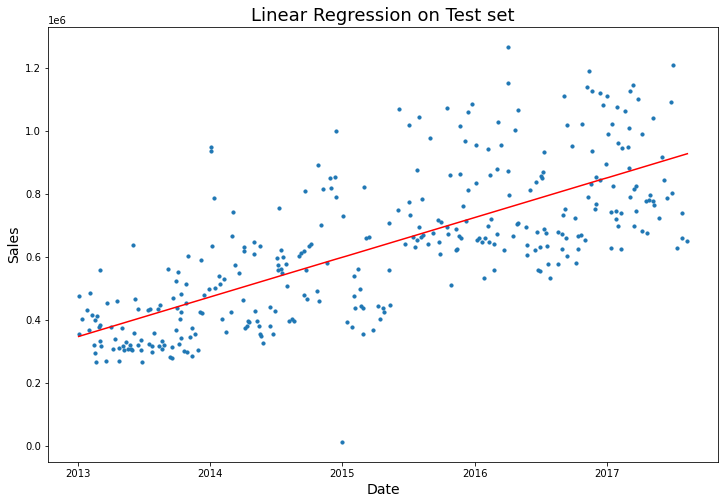

In [11]:
lin_fig = plt.figure(figsize=(12, 8))
plt.scatter(X_test['date'], y_test, s=10)
plt.plot(X_test['date'], y_lin_pred, '-', color='r')
plt.title("Linear Regression on Test set", fontsize=18)
plt.xlabel('Date', size=14)
plt.ylabel('Sales', size=14)

In [12]:
# Computing Error from Linear Regression
print("Error from Linear Regression is", error(y_lin_pred, y_test))

Error from Linear Regression is 0.3197


## Trend

In [13]:
# Recall
print(df.shape)
df.head()

(1684, 4)


,date,sales,onpromotion,time
0,2013-01-01,2511.618999,0,0
1,2013-01-02,496092.417944,0,1
2,2013-01-03,361461.231124,0,2
3,2013-01-04,354459.677093,0,3
4,2013-01-05,477350.121229,0,4


In [14]:
trendSeries = df[['date', 'sales']].set_index("date").to_period("D")

# Separate last 20% samples for test
trendSeries_test = trendSeries.tail(365)
trendSeries= trendSeries.drop(trendSeries_test.index)

y_trend_test = trendSeries_test['sales']

# Check the shape
print(trendSeries.shape, y_trend_test.shape)
trendSeries.head()

(1319, 1) (365,)


,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


In [15]:
# Average with appropriate parameters for trend estimation.
moving_trend = trendSeries.rolling(
    window=730,       # 730-day window
    center=True,      # puts the average at the center of the window
    min_periods=365,  # choose about half the window size
).mean() 

Text(0, 0.5, 'Sales')

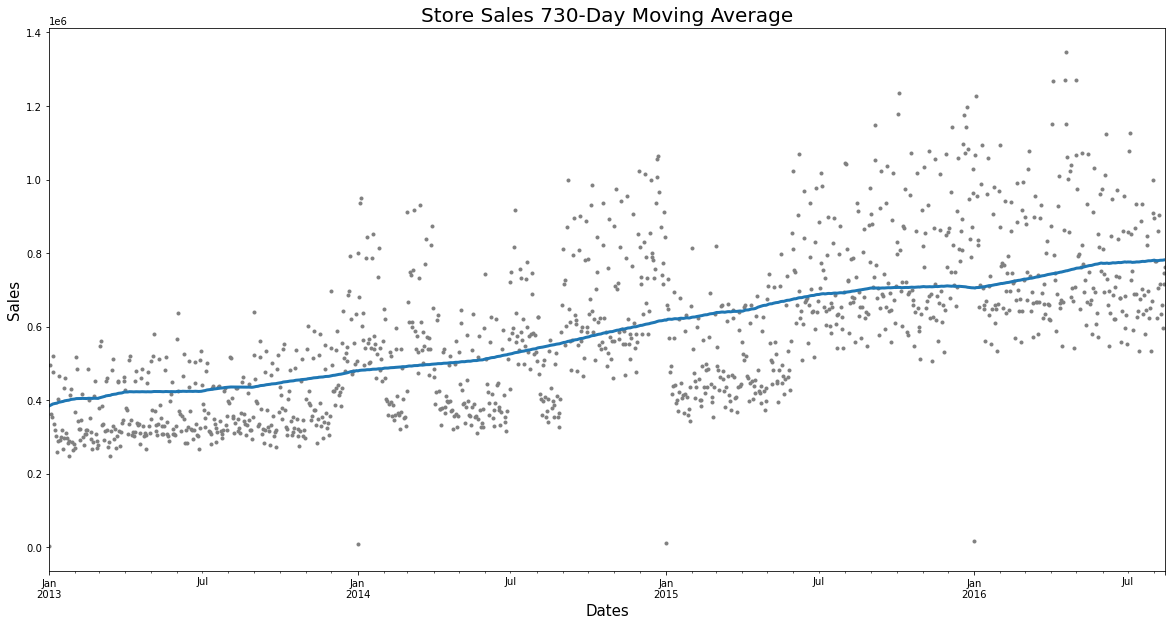

In [16]:
trend_ax1 = trendSeries.plot(figsize=(20, 10), style=".", color="0.5", legend=False)

moving_trend.plot(
    ax=trend_ax1, linewidth=3, legend=False,
)

trend_ax1.set_title("Store Sales 730-Day Moving Average", fontsize=20)
plt.xlabel("Dates", size=15)
plt.ylabel("Sales", size=15)

In [17]:
from statsmodels.tsa.deterministic import DeterministicProcess

trend_dp = DeterministicProcess(
    index=trendSeries.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument

X_trend = trend_dp.in_sample()
print(X_trend.shape)
X_trend.head()

(1319, 2)


,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


In [18]:
y_trend = trendSeries["sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
trend_model = LinearRegression(fit_intercept=False)
trend_model.fit(X_trend, y_trend)

y_trend_pred = pd.Series(trend_model.predict(X_trend), index=X_trend.index)

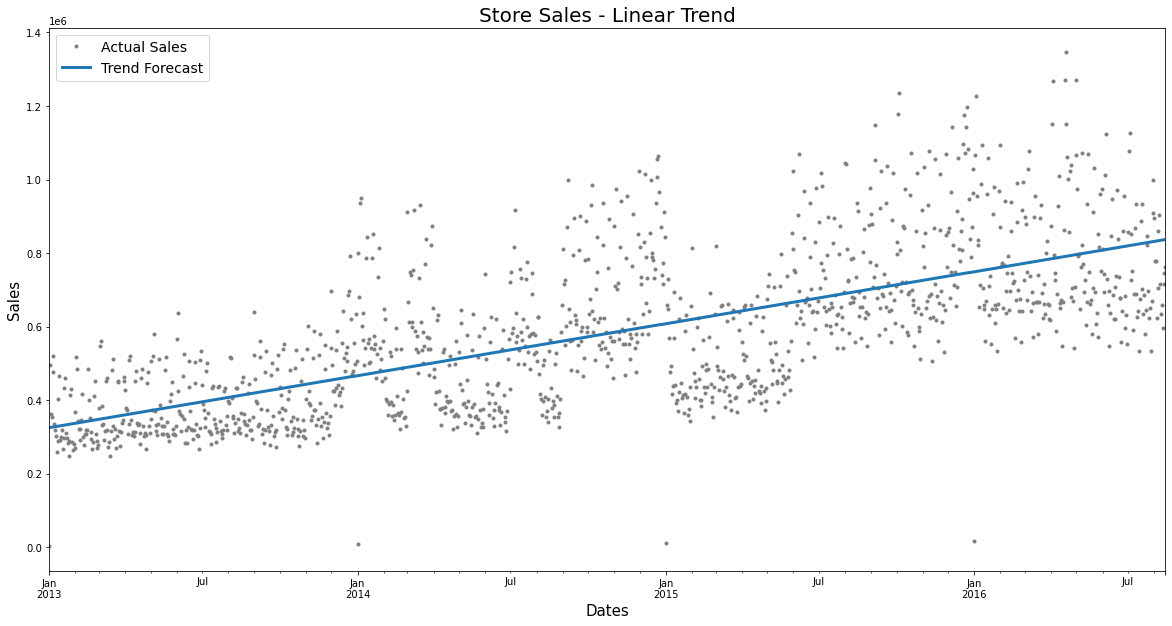

In [19]:
trend_ax2 = trendSeries.plot(figsize=(20,10), style=".", color="0.5")
y_trend_pred.plot(ax=trend_ax2, linewidth=3, label="Linear Trend")

trend_ax2.set_title("Store Sales - Linear Trend", fontsize=20)

trendlabels1 = ['Actual Sales', 'Trend Forecast']
trend_ax2.legend(labels=trendlabels1, prop={'size': 14})
_ = plt.xlabel("Dates", size=15)
_ = plt.ylabel("Sales", size=15)

In [20]:
# Out of Sample for next 365 days
X_trend_oos = trend_dp.out_of_sample(steps=365)
y_trend_fore = pd.Series(trend_model.predict(X_trend_oos), index=X_trend_oos.index)
y_trend_fore.head()

2016-08-15    837329.542524
2016-08-16    837717.602152
2016-08-17    838105.661780
2016-08-18    838493.721408
2016-08-19    838881.781036
Freq: D, dtype: float64

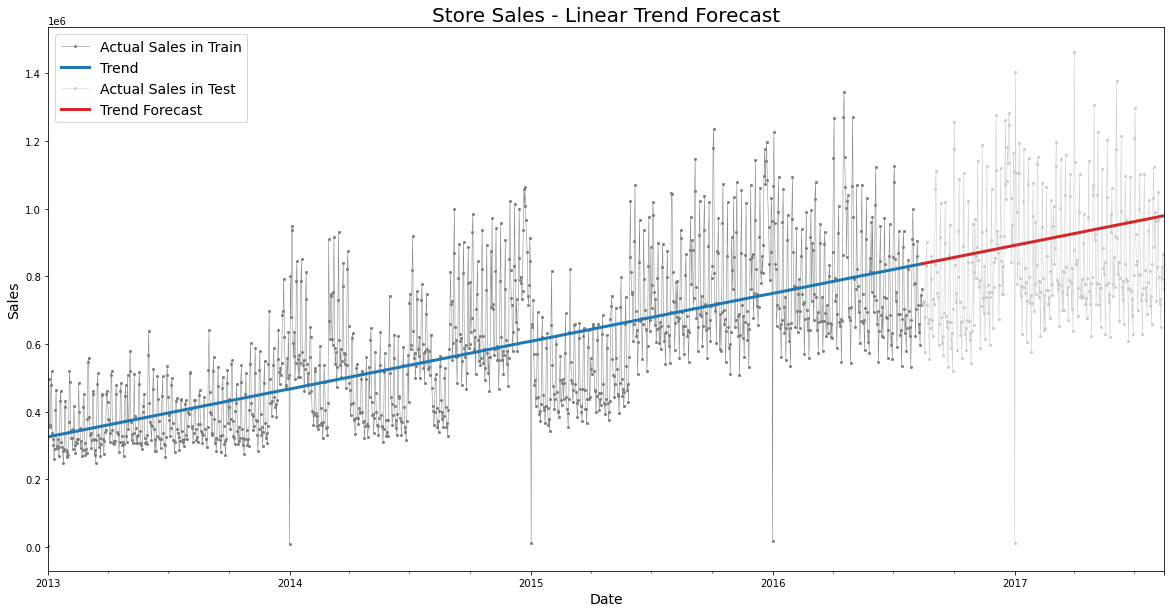

In [21]:
trend_ax3 = trendSeries["2013-01":].plot(figsize=(20,10), linewidth=0.5, marker="o", markersize=2, color="0.5")
trend_ax3 = y_trend_pred["2013-01":].plot(ax=trend_ax3, linewidth=3, label="Trend")
trend_ax3 = trendSeries_test["2016-08-15":].plot(ax=trend_ax3, linewidth=0.5, marker="o", markersize=2, color="0.8")
trend_ax3 = y_trend_fore.plot(ax=trend_ax3, linewidth=3, label="Trend Forecast", color="C3")

trend_ax3.set_title("Store Sales - Linear Trend Forecast", fontsize=20)
trendlabels = ['Actual Sales in Train', 'Trend', 'Actual Sales in Test', 'Trend Forecast']
_ = trend_ax3.legend(labels=trendlabels, prop={'size': 14})
_ = plt.xlabel("Date", size=14)
_ = plt.ylabel("Sales", size=14)

In [22]:
print("Error from Trend forecasting is", error(y_trend_fore, y_trend_test))

Error from Trend forecasting is 0.3156


## Seasonality

In [23]:
seasonal = dataset.groupby(by="date").sum()
seasonal = pd.DataFrame(seasonal['sales'])
seasonal = seasonal.to_period('D')

print(seasonal.shape)
seasonal.head()

(1684, 1)


,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


### 1) Seasonal Plot

In [24]:
# Days within a week
seasonal["day"] = seasonal.index.dayofweek
seasonal["week"] = seasonal.index.week

In [25]:
# Days within a year
seasonal["dayofyear"] = seasonal.index.dayofyear
seasonal["year"] = seasonal.index.year

print(seasonal.shape)
seasonal.head()

(1684, 5)


,sales,day,week,dayofyear,year
date,,,,,
2013-01-01,2511.618999,1,1,1,2013
2013-01-02,496092.417944,2,1,2,2013
2013-01-03,361461.231124,3,1,3,2013
2013-01-04,354459.677093,4,1,4,2013
2013-01-05,477350.121229,5,1,5,2013


In [26]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )

    plt.tight_layout()      # added to give space between two plots
        
    return ax

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

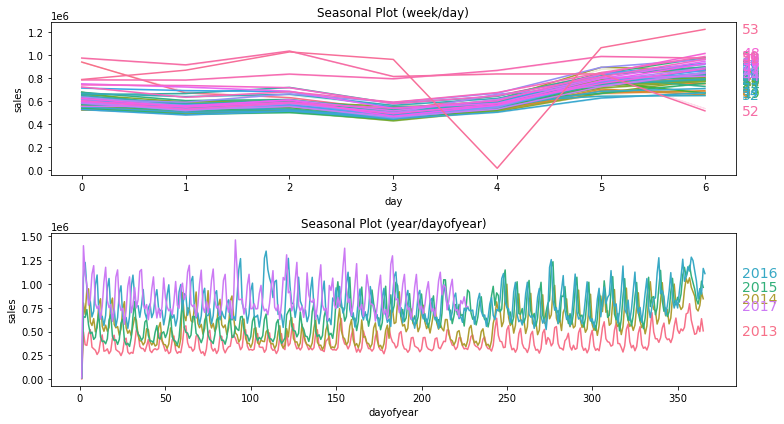

In [27]:
season_fig, (season_ax1, season_ax2) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(seasonal, y="sales", period="week", freq="day", ax=season_ax1)
seasonal_plot(seasonal, y="sales", period="year", freq="dayofyear", ax=season_ax2)

### 2) Periodogram

In [28]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.xaxis.set_tick_params(width=3)   # added to make the ticks thicker
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram", fontsize=15)  # added to set title size at 15
    ax.figure.set_size_inches(15, 8)    # added to adjust plot size
    return ax

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

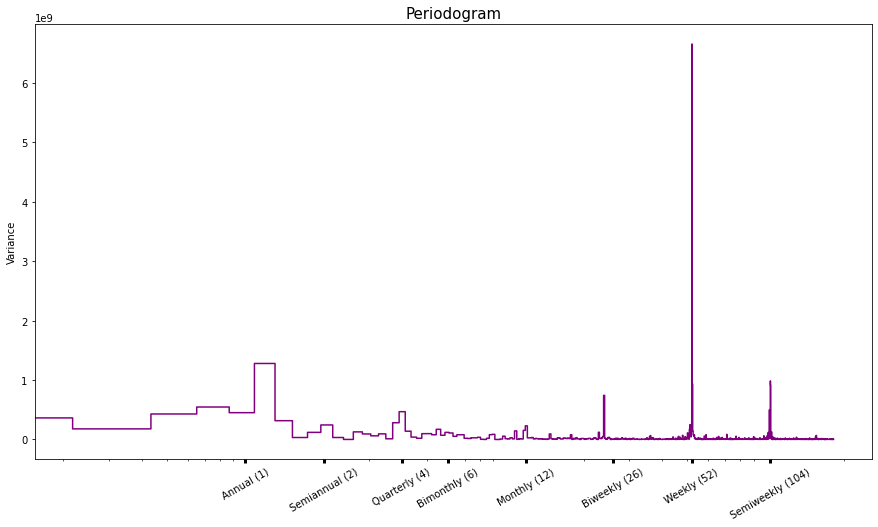

In [29]:
plot_periodogram(seasonal.sales)

In [30]:
# Use 4 pairs; 
# From right to left, the periodogram falls off after Quarterly(4)
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=4)  # 78 sin/cos pairs for "A"nnual seasonality

season_dp = DeterministicProcess(
    index=seasonal.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season= season_dp.in_sample()  # create features for dates in tunnel.index

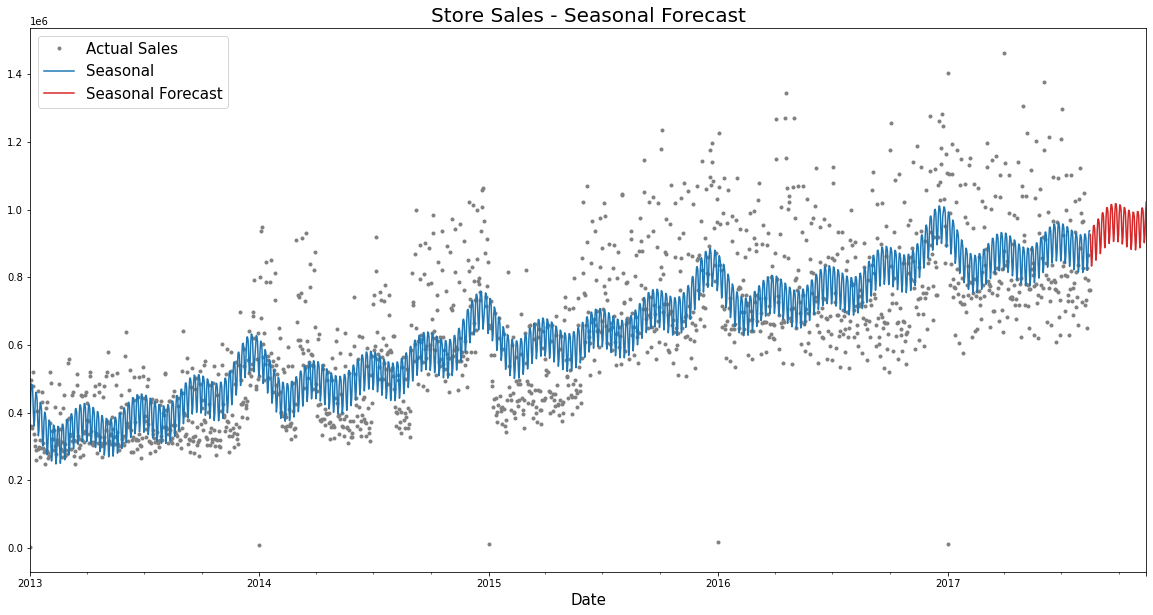

In [31]:
y_season = seasonal["sales"]

season_model = LinearRegression(fit_intercept=False)
_ = season_model.fit(X_season, y_season)

# sales valued computed from season_model
y_season_pred = pd.Series(season_model.predict(X_season), index=y_season.index) 

# Forecasting next 90 days of sales
X_season_fore = season_dp.out_of_sample(steps=90)
y_season_fore = pd.Series(season_model.predict(X_season_fore), index=X_season_fore.index)

# Plotting
season_ax3 = y_season.plot(figsize=(20,10), color='0.5', style='.')
season_ax3 = y_season_pred.plot(ax=season_ax3, label="Seasonal")
season_ax3 = y_season_fore.plot(ax=season_ax3, label="Seasonal Forecast", color='C3')

season_ax3.set_title("Store Sales - Seasonal Forecast", fontsize=20)
seasonlabels = ['Actual Sales', 'Seasonal', 'Seasonal Forecast']
_ = season_ax3.legend(labels=seasonlabels, prop={'size': 15})
_ = plt.xlabel('Date', size=15)